# Primeira parte: Aprendizagem supervisionada

In [2]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import matthews_corrcoef
from scipy.cluster.hierarchy import dendrogram, linkage
import joblib

In [3]:
#aumentado a capacidade de visualização de colunas e linhas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows',1000)

## Combinação dos dados

Uma nova perspectiva: dataset longo. Quando estamos tentando agregar mais dados à um dataset pré estabelecido, é comum pensarmos inicialmente na extração das features diretamente para novas colunas. Entretanto, esse método costuma gerar problemas durante o pré processamento. Não haverá garantias de, por exemplo, balanceamento e preenchimento das colunas, de forma que possa gerar células com valores nulos, zerados, ou pouco significantes caso haja atributos singulares para uma única instância.   
Dessa forma, vamos optar primeiro por combinar os dados da tabela inicial 'sinais.csv' e os muitos arquivos 'JSON' da pasta 'sinais_frames' de forma que sejam criadas novas linhas ao invés de colunas.

In [ ]:
import json
import os
from tqdm import tqdm
import sys

#Gerando o CSV Final a partir dos JSONs

csv_input_file = 'sinais.csv'
json_folder = 'sinais_frames' 
csv_output_file = 'corpus_completo.csv' 


try:
    df_meta = pd.read_csv(csv_input_file)
except FileNotFoundError:
    print(f"Erro: O arquivo '{csv_input_file}' não foi encontrado.")
    sys.exit()

if not os.path.isdir(json_folder):
    print(f"Erro: A pasta '{json_folder}' não foi encontrada.")
    sys.exit()

all_data_rows = []

print("Iniciando o processamento ...")

for index, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0]):
    if pd.isna(row['file_name']):
        continue

    json_filename = row['file_name'].strip()
    json_path = os.path.join(json_folder, json_filename)

    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            try:
                # Carrega o dicionário principal do JSON
                data = json.load(f)
                                
                # 1. Acessa a lista de frames que está sob a chave "frames"
                frames_list = data.get('frames', [])
                
                for frame_data in frames_list:
                    # 2. Pega o número do frame e a lista de keypoints de dentro de cada objeto de frame
                    frame_index = frame_data.get('frame')
                    keypoints_list = frame_data.get('keypoints', [])
                    
                    if frame_index is None:
                        continue # Pula se não encontrar o número do frame

                    # 3. Itera sobre cada keypoint para extrair seus dados
                    # O dicionário foi criado a partir da estrutura do JSON
                    for landmark_data in keypoints_list:
                        processed_row = {
                            'file_name': json_filename,
                            'width': row['width'],
                            'height': row['height'],
                            'duration_sec': row['duration_sec'],
                            'num_frames_video': row['num_frames'],
                            'sinal': row['sinal'],
                            'interprete': row['interprete'],
                            'keyframe_index': frame_index,
                            'landmark_id': landmark_data.get('id'),
                            'x': landmark_data.get('x'),
                            'y': landmark_data.get('y'),
                            'z': landmark_data.get('z'),
                            'visibility': landmark_data.get('visibility')
                        }
                        all_data_rows.append(processed_row)

            except json.JSONDecodeError:
                print(f"\nAviso: O arquivo '{json_filename}' está corrompido ou não é um JSON válido.")
            except Exception as e:
                print(f"\nAviso: Ocorreu um erro inesperado ao processar o arquivo '{json_filename}': {e}")

print("\nProcessamento concluído. Criando o arquivo CSV final...")

if not all_data_rows:
    print("Aviso: Nenhum dado foi processado. O CSV de saída estará vazio.")
    print("Verifique os arquivos JSON dentro da pasta.")
else:
    df_final = pd.DataFrame(all_data_rows)
    df_final.to_csv(csv_output_file, index=False)
    print(f"Sucesso! O arquivo '{csv_output_file}' foi criado com {len(df_final)} linhas.")

A ideia desse script foi transformar cada landmark (verificar a estrutura do JSON na pasta para melhor visualização) de cada frame em uma única linha, tornando acessível o cruzamento de toda informação dos arquivos 'JSON' com nossa tabela inicial de metadados.
Os dados resultantes no dataset 'corpus_completo.csv' são keypoints extraídos seguindo o mapeamento disponível em 'Descrição do Corpus de Keyframes em Libras.pdf' para cada segundo de vídeo e cada segundo possui 30 frames, e como são alguns segundos por vídeo e vários deles, temos um dataset longo com ~9.4 milhões de linhas. 

## Compreendendo os dados

Os sinais de libras são perspectivas abstratas cujos significados são construídos principalmente pelo movimento. O que temos agora de cada keypoint são dados posicionais no espaço e visibilidade dele nos respectivos momentos do vídeo. Somente métricas estatísticas não são suficientes para descrever de forma significativa e robusta o que é um sinal de libras para que o modelo compreenda com eficácia. Por isso, é importante criar novas features/métricas  que possam carregar em seus valores algo mais concreto. Vamos explorar alguns tipos de features que podemos utilizar com base em processamento de frames e detecção de movimento para o nosso problema:  

Features espaciais ou geométricas: essas features são calculadas dentro de cada frame e são capazes de representar variações de posição e rotação do intérprete. Em vez de usar as coordenadas x, y, e z brutas, extraímos as relações que elas possuem umas com as outras.

Features temporais ou dinâmicas: essas features capturam o movimento ao longo do tempo, analisando a diferença entre frames consecutivos. Trazendo para o nosso contexto, essas seriam as que trariam maior significado, uma vez que os sinais de libras têm seu significado construído pelo movimento, como mencionado anteriormente.

Agregação estatística: possuindo as features dos tipos anteriores, agora sim as métricas estatísticas podem agregar mais significado.

In [ ]:
input_long_csv = 'corpus_completo.csv'
output_wide_csv = 'corpus_amplo.csv'  #um novo csv de sáida


print(f"Carregando o arquivo de dados: '{input_long_csv}'...")
try:
    df_long = pd.read_csv(input_long_csv)
except FileNotFoundError:
    print(f"ERRO: O arquivo '{input_long_csv}' não foi encontrado.")
    exit()

print("Iniciando a transformação de formato longo para amplo...")
print(f"Número de linhas iniciais: {len(df_long)}")

#Pivotagem
print("Passo 1/5: Pivotando a tabela para cálculos eficientes...")
df_pivoted = df_long.pivot_table(
    index=['file_name', 'keyframe_index'],
    columns='landmark_id',
    values=['x', 'y', 'z']
)
df_pivoted.columns = [f'{val}_{idx}' for val, idx in df_pivoted.columns]
df_pivoted.reset_index(inplace=True)

#Features espaciais (distâncias) 
print("Passo 2/5: Calculando features espaciais (distâncias)...")
p_nose = df_pivoted[['x_0', 'y_0', 'z_0']].values
p_wrist_left = df_pivoted[['x_15', 'y_15', 'z_15']].values
p_wrist_right = df_pivoted[['x_16', 'y_16', 'z_16']].values

df_pivoted['dist_wrist_r_nose'] = np.linalg.norm(p_wrist_right - p_nose, axis=1)
df_pivoted['dist_wrist_l_nose'] = np.linalg.norm(p_wrist_left - p_nose, axis=1)
df_pivoted['dist_wrists'] = np.linalg.norm(p_wrist_right - p_wrist_left, axis=1)

#Features Temporais (velocidade) 
print("Passo 3/5: Calculando features temporais (velocidade)...")

# Velocidade do pulso direito (landmark 16)
vel_components_r = df_pivoted.groupby('file_name')[['x_16', 'y_16', 'z_16']].diff().fillna(0)
df_pivoted['vel_wrist_r_mag'] = np.linalg.norm(vel_components_r, axis=1)

#Velocidade do pulso esquerdo (landmark 15) 
vel_components_l = df_pivoted.groupby('file_name')[['x_15', 'y_15', 'z_15']].diff().fillna(0)
df_pivoted['vel_wrist_l_mag'] = np.linalg.norm(vel_components_l, axis=1)

#Agregação estatística
print("Passo 4/5: Agregando estatísticas para criar o formato amplo...")

features_to_agg = [
    'dist_wrist_r_nose',
    'dist_wrist_l_nose',
    'dist_wrists',
    'vel_wrist_r_mag',
    'vel_wrist_l_mag' 
]

agg_functions = ['mean', 'std', 'min', 'max']
agg_dict = {feat: agg_functions for feat in features_to_agg}

df_wide = df_pivoted.groupby('file_name').agg(agg_dict)
df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

#Junção dos metadados
print("Passo 5/5: Adicionando metadados (sinal, interprete)...")
df_meta = df_long[['file_name', 'sinal', 'interprete']].drop_duplicates()
df_final_wide = pd.merge(df_wide, df_meta, on='file_name', how='left')

#Salvando o resultado final
df_final_wide.to_csv(output_wide_csv, index=False)

print("\nProcessamento concluído com sucesso!")
print(f"O arquivo '{output_wide_csv}' foi gerado com {len(df_final_wide)} linhas e {len(df_final_wide.columns)} colunas.")
print("\nAmostra do resultado final:")
print(df_final_wide.head())

Carregando o arquivo de dados: 'corpus_completo.csv'...
Iniciando a transformação de formato longo para amplo...
Número de linhas iniciais: 9400809
Passo 1/5: Pivotando a tabela para cálculos eficientes...
Passo 2/5: Calculando features espaciais (distâncias)...
Passo 3/5: Calculando features temporais (velocidade)...
Passo 4/5: Agregando estatísticas para criar o formato amplo...
Passo 5/5: Adicionando metadados (sinal, interprete)...

Processamento concluído com sucesso!
O arquivo 'corpus_amplo.csv' foi gerado com 2501 linhas e 23 colunas.

Amostra do resultado final:
           file_name  dist_wrist_r_nose_mean  dist_wrist_r_nose_std  \
0   Adição_AP_1.json              517.534844             161.906176   
1  Adição_AP_10.json              483.648126             151.913577   
2   Adição_AP_2.json              484.490372             158.260312   
3   Adição_AP_3.json              494.845376             155.920068   
4   Adição_AP_4.json              491.487799             163.187512 

*Antes de calcular as distâncias, normalizamos todas as coordenadas tendo como centro o nariz (landmark 0), a fim de centralizar a pessoa do vídeo no sistema de coordenadas*

O intuito desse script era voltar ao tamanho original do primeiro 'csv', de forma que cada linha representasse um vídeo no seu respectivo 'JSON', e nessa linha toda a informação equivalente àquele vídeo tenha sido processada para as nossas novas features:

dist_wrist_r_nose e dist_wrist_l_nose: distância dos pulsos direito e esquerdo, respectivamente, até o nariz.
dist_wrists: distância entre os pulsos
vel_wrist_r_mag e vel_wrist_l_mag: magnitude do vetor de velocidade para os pulsos direito e esquerdo, respectivamente.

Com a agregação estatística, os modelos podem ser capazes de detectar e agrupar padrões de movimento nos sinais, como sinais mais lentos, rápidos, longe do rosto ou próximo, entre outros.

## Exploração e pré-processamento

In [4]:
#Vamos dar uma olhada na cara do nosso novo CSV
data = pd.read_csv('corpus_amplo.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   file_name               2501 non-null   object 
 1   dist_wrist_r_nose_mean  2501 non-null   float64
 2   dist_wrist_r_nose_std   2501 non-null   float64
 3   dist_wrist_r_nose_min   2501 non-null   float64
 4   dist_wrist_r_nose_max   2501 non-null   float64
 5   dist_wrist_l_nose_mean  2501 non-null   float64
 6   dist_wrist_l_nose_std   2501 non-null   float64
 7   dist_wrist_l_nose_min   2501 non-null   float64
 8   dist_wrist_l_nose_max   2501 non-null   float64
 9   dist_wrists_mean        2501 non-null   float64
 10  dist_wrists_std         2501 non-null   float64
 11  dist_wrists_min         2501 non-null   float64
 12  dist_wrists_max         2501 non-null   float64
 13  vel_wrist_r_mag_mean    2501 non-null   float64
 14  vel_wrist_r_mag_std     2501 non-null   

In [ ]:
#Aqui suas estatísticas descritivas
data.describe()

,dist_wrist_r_nose_mean,dist_wrist_r_nose_std,dist_wrist_r_nose_min,dist_wrist_r_nose_max,dist_wrist_l_nose_mean,dist_wrist_l_nose_std,dist_wrist_l_nose_min,dist_wrist_l_nose_max,dist_wrists_mean,dist_wrists_std,dist_wrists_min,dist_wrists_max,vel_wrist_r_mag_mean,vel_wrist_r_mag_std,vel_wrist_r_mag_min,vel_wrist_r_mag_max,vel_wrist_l_mag_mean,vel_wrist_l_mag_std,vel_wrist_l_mag_min,vel_wrist_l_mag_max
count,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.0,2501.000000,2501.000000,2501.000000,2501.0,2501.000000
mean,522.232634,186.916814,237.402216,705.759832,566.119431,132.958221,365.468172,701.679725,373.644522,107.167917,206.801484,520.487773,11.004414,14.890192,0.0,65.147156,8.251764,10.917737,0.0,47.686325
std,282.508901,122.021318,137.070508,377.477200,332.214229,118.289138,305.705961,380.622008,218.603028,68.370888,170.771573,292.674324,6.369417,8.670403,0.0,39.179148,6.383262,8.416242,0.0,37.334111
min,66.113369,0.828145,6.409493,103.587282,71.787075,1.331522,34.216072,97.124498,52.044858,3.568942,2.045703,64.384024,0.163685,0.317874,0.0,1.011187,0.204639,0.424042,0.0,1.414249
25%,295.857985,90.692917,142.439052,420.396504,296.604035,19.349410,169.580060,399.981250,204.982928,53.458017,90.094575,304.420789,5.948200,8.386417,0.0,36.346886,2.152076,2.491176,0.0,12.041744
50%,474.782978,166.671458,211.207811,624.435827,469.667576,109.391483,261.231782,617.331953,334.116869,94.285668,150.722565,469.260057,10.347038,13.603705,0.0,59.135441,7.818321,10.470071,0.0,44.944855
75%,656.418761,256.578801,308.016689,928.205367,736.582053,189.757205,432.921480,919.959750,517.956636,148.643322,273.529003,681.006609,15.191137,20.208068,0.0,87.727547,12.740547,16.553123,0.0,69.723454
max,1153.803547,513.577416,717.833727,1435.784174,1371.749823,481.470474,1353.163408,1431.001674,1120.434538,350.685183,786.031262,1600.956683,42.628098,46.053179,0.0,250.050005,32.436332,39.088946,0.0,303.030894


In [5]:
# Removendo colunas desnecessárias 
data = data.drop(columns=["interprete","file_name"],axis=1,)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dist_wrist_r_nose_mean  2501 non-null   float64
 1   dist_wrist_r_nose_std   2501 non-null   float64
 2   dist_wrist_r_nose_min   2501 non-null   float64
 3   dist_wrist_r_nose_max   2501 non-null   float64
 4   dist_wrist_l_nose_mean  2501 non-null   float64
 5   dist_wrist_l_nose_std   2501 non-null   float64
 6   dist_wrist_l_nose_min   2501 non-null   float64
 7   dist_wrist_l_nose_max   2501 non-null   float64
 8   dist_wrists_mean        2501 non-null   float64
 9   dist_wrists_std         2501 non-null   float64
 10  dist_wrists_min         2501 non-null   float64
 11  dist_wrists_max         2501 non-null   float64
 12  vel_wrist_r_mag_mean    2501 non-null   float64
 13  vel_wrist_r_mag_std     2501 non-null   float64
 14  vel_wrist_r_mag_min     2501 non-null   

*Importante: ao remover colunas, sempre verifique as duplicatas*

In [6]:
dupes = data.duplicated()
sum(dupes)

11

In [7]:
data = data.drop_duplicates(keep='first')

In [8]:
dupes = data.duplicated()
sum(dupes)

0

In [9]:
#Por enquanto vamos deixar assim
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2490 entries, 0 to 2500
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dist_wrist_r_nose_mean  2490 non-null   float64
 1   dist_wrist_r_nose_std   2490 non-null   float64
 2   dist_wrist_r_nose_min   2490 non-null   float64
 3   dist_wrist_r_nose_max   2490 non-null   float64
 4   dist_wrist_l_nose_mean  2490 non-null   float64
 5   dist_wrist_l_nose_std   2490 non-null   float64
 6   dist_wrist_l_nose_min   2490 non-null   float64
 7   dist_wrist_l_nose_max   2490 non-null   float64
 8   dist_wrists_mean        2490 non-null   float64
 9   dist_wrists_std         2490 non-null   float64
 10  dist_wrists_min         2490 non-null   float64
 11  dist_wrists_max         2490 non-null   float64
 12  vel_wrist_r_mag_mean    2490 non-null   float64
 13  vel_wrist_r_mag_std     2490 non-null   float64
 14  vel_wrist_r_mag_min     2490 non-null   float

In [10]:
#Análise de balanceamento
data["sinal"].value_counts()

sinal
Apostila            100
Capítulo            100
Classe              100
Biologia            100
Contexto            100
Conceito            100
Colega              100
Coesão              100
Coerência           100
Ensinar             100
Escola              100
Estudar             100
Filosofia           100
Física              100
Curso               100
Dicionário          100
Disciplina          100
História            100
Geografia           100
Adição               99
Aluno                99
Apontador            99
Bolsa de Estudos     99
Antropologia         97
Ângulo               97
Name: count, dtype: int64

Os vídeos utilizados para extração dos keyframes foram criados com o objetivo de gerar uma base balanceada. Análises e modificações adicionais serão referenciadas com as partes posteriores onde for preciso algo a mais, se necessário. 

In [11]:
#Isolando variáveis independentes e dependentes
X = data.drop(['sinal'], axis=1)
y = data['sinal']

In [13]:
#Divisão entre treino e teste, balanceando as classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 20% para teste
    random_state=42,  
    stratify=y        
)

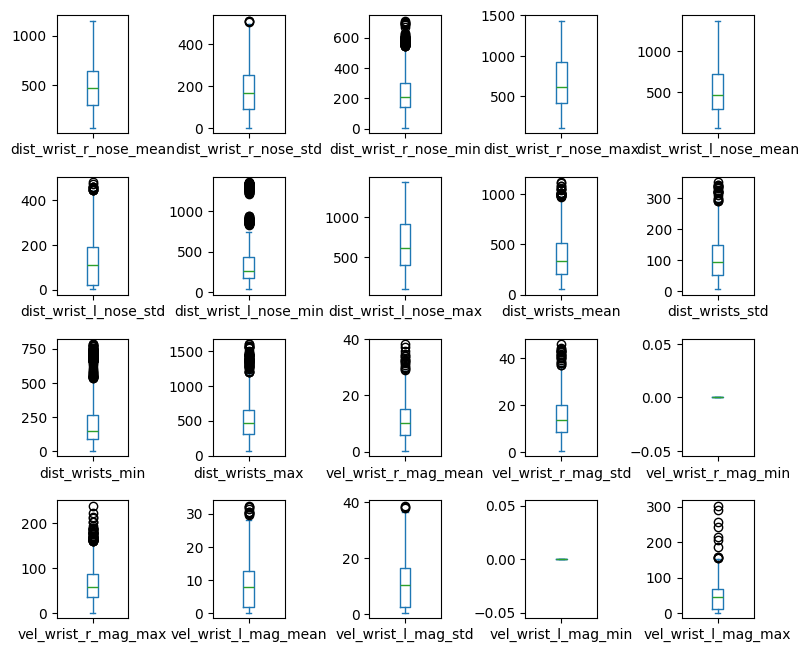

In [40]:
#Visualização de outliers
import matplotlib.pyplot as plt
X_train[X_train.columns].plot(kind='box',
                        layout=(5,5),
                        subplots=True,
                        figsize=(8,8),
                        sharex=False)
plt.tight_layout()
plt.show()

Uma característica interessante em novas colunas com valores absolutos, é que seus outliers podem servir também como métricas de identificação para os modelos e, assim, melhorar a predizão do modelo. Por exemplo, na distância máxima entre os pulsos (linha 3, coluna 2), os pontos nos quais a distância entre ele é alta pode indicar um sinal que é executado com apenas uma mão, o que classifica um tipo de sinal de libras.
Por enquanto, vamos processar sem removê-los.

In [14]:
label_encoder = LabelEncoder()

# Fit_transform no atributo alvo do treino
y_train_encoded = label_encoder.fit_transform(y_train)

# Apenas transform no atributo alvo do teste
y_test_encoded = label_encoder.transform(y_test)

## Treinamento

*Nesse notebook, a métrica utilizada para medir o desempenho dos modelos será o F1_score, o qual tentaremos deixar próximo de 0.9. Alcançando esse objetivo, não iremos mais adiante*

In [18]:
X_train.shape

(1992, 20)

## Árvore de decisão (Random Forest)

In [21]:
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Instanciar o objeto de validação cruzada estratificada.
# K=25 foi escolhido após testes com múltiplos de 5, até o valor 25, por causa do balanceamento das classes. 
kfold_estratificado = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)


#Validação Cruzada
# A função 'cross_val_score' faz todo o trabalho do loop para nós.
# Ela treina, avalia e retorna os scores para cada um dos K folds.
print("Iniciando a validação cruzada K-Fold (K=25)...")

scores = cross_val_score(
    estimator=modelo,
    X=X_train,
    y=y_train_encoded,
    cv=kfold_estratificado,
    scoring='f1_macro' # Métrica de avaliação
)

print("\nValidação Cruzada concluída.")
print(f"F1-score para cada um dos 25 folds: {np.round(scores, 3)}")
print(f"F1-score Médio: {scores.mean():.4f}")
print(f"Desvio Padrão do F1-score: {scores.std():.4f}")

Iniciando a validação cruzada K-Fold (K=25)...

Validação Cruzada concluída.
F1-score para cada um dos 25 folds: [0.961 0.975 0.932 0.944 0.962 0.947 0.961 0.99  0.938 0.973 0.964 0.945
 0.949 0.961 0.976 0.923 0.965 0.959 0.989 0.915 0.973 0.962 0.935 0.93
 0.932]
F1-score Médio: 0.9544
Desvio Padrão do F1-score: 0.0195


In [ ]:
# Treina o modelo final com todo o conjunto de treino
modelo.fit(X_train, y_train_encoded) 

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
#Validação final com o conjunto de teste
teste_randomforest = modelo.predict(X_test)

# Calcula a o f1_score no conjunto de teste
f1_score_randomforest = f1_score(y_test_encoded, teste_randomforest, average='macro')

print(f"\nF1-score final no conjunto de teste: {f1_score_randomforest:.4f}")


F1-score final no conjunto de teste: 0.9677


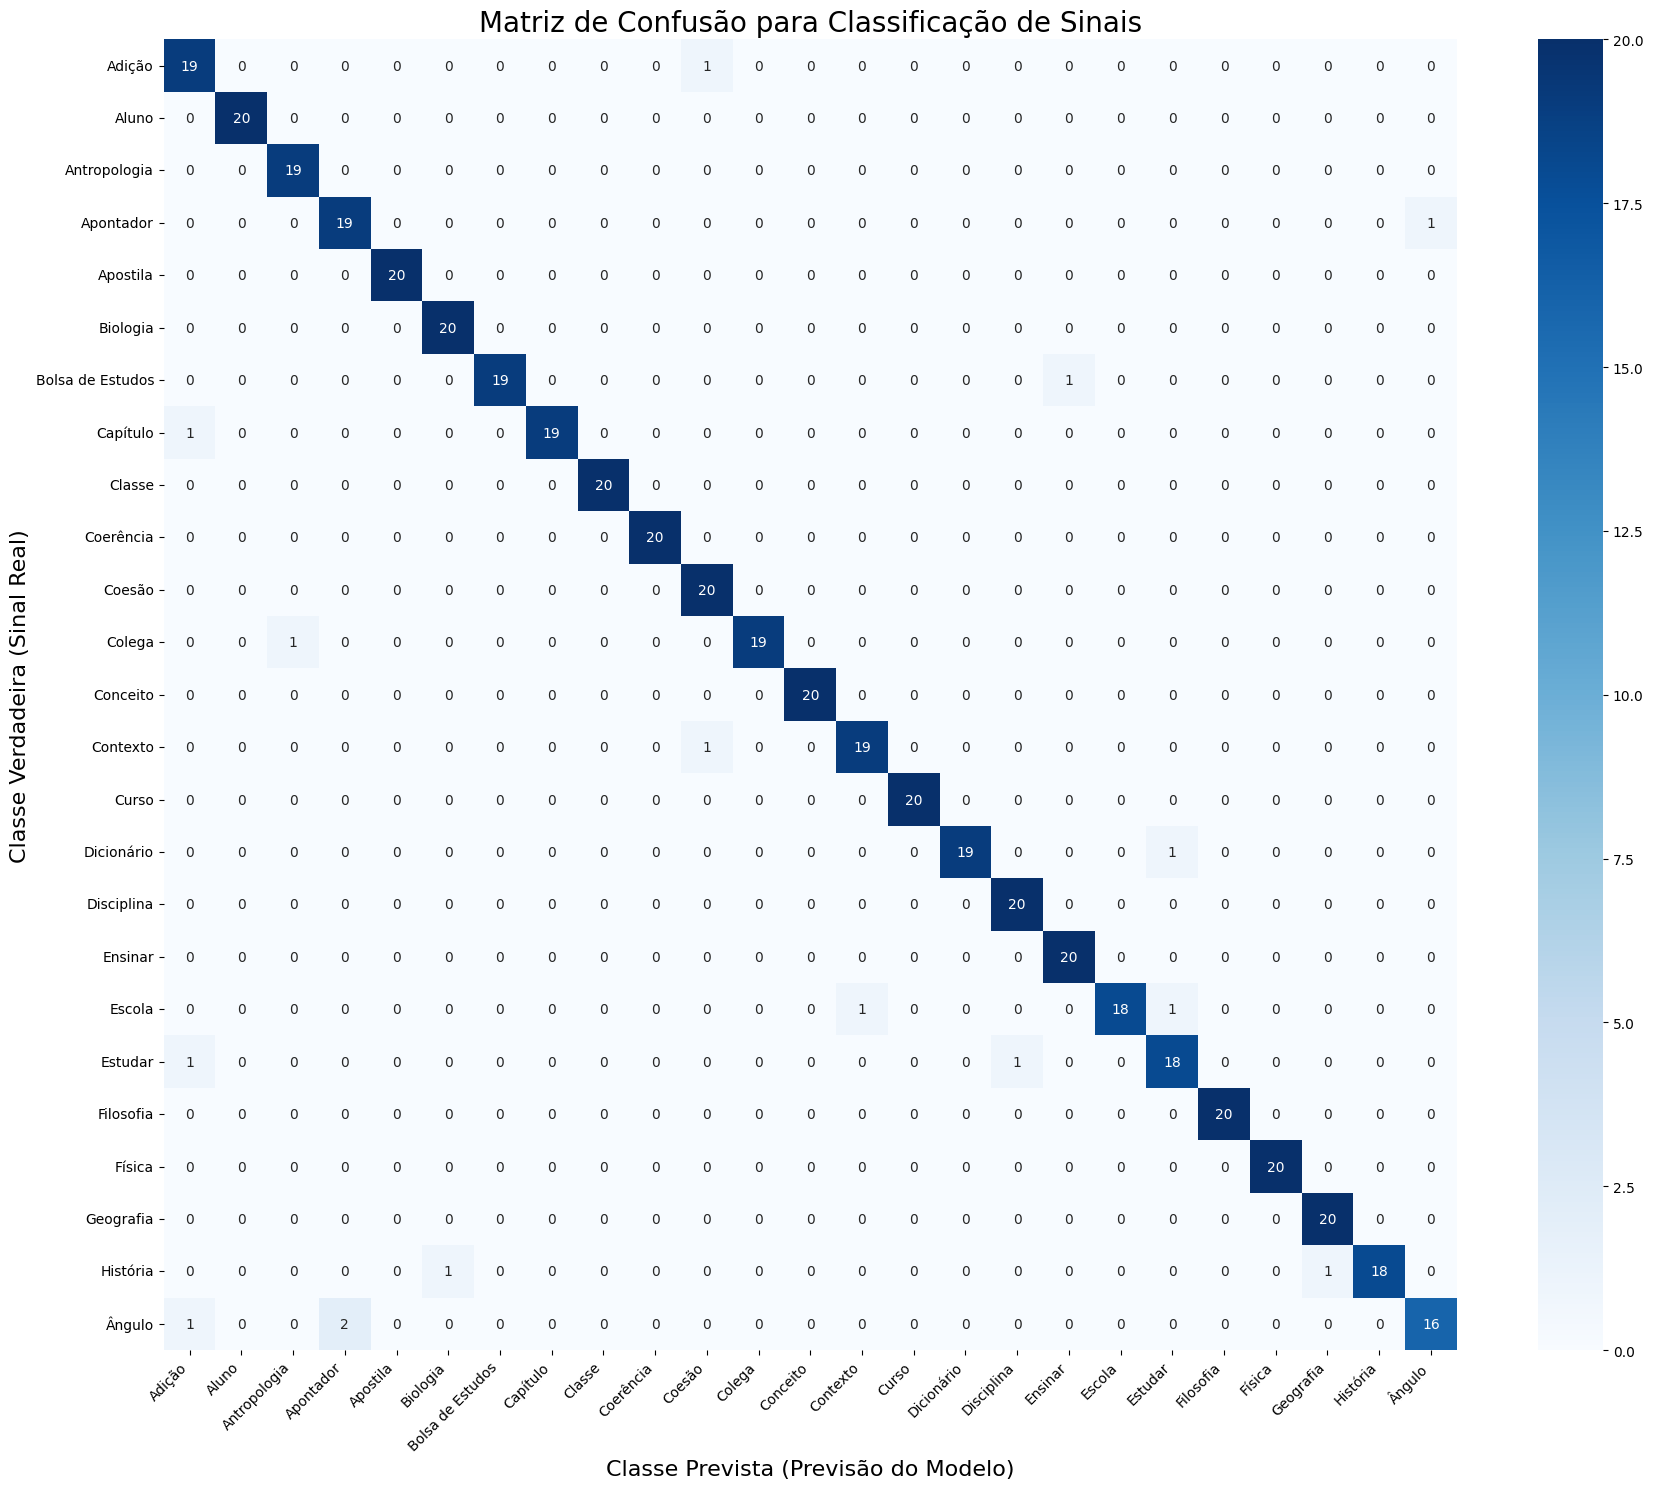

In [ ]:
#Matriz de confusão para vermos onde o modelo erra mais

cm_rf = confusion_matrix(y_test_encoded, teste_randomforest)

#Obtém os nomes das classes (sinais) a partir do encoder
nomes_das_classes_rf = label_encoder.classes_

# 3. Criar a Visualização (Heatmap)
plt.figure(figsize=(18, 15)) # Aumentar o tamanho da figura para caberem as 25 classes

sns.heatmap(cm_rf, 
            annot=True,     # Escreve os números dentro de cada célula
            fmt='d',        # Formata os números como inteiros
            cmap='Blues',   # Esquema de cores
            xticklabels=nomes_das_classes_rf, 
            yticklabels=nomes_das_classes_rf)

plt.title('Matriz de Confusão para Classificação de Sinais', fontsize=20)
plt.ylabel('Classe Verdadeira (Sinal Real)', fontsize=16)
plt.xlabel('Classe Prevista (Previsão do Modelo)', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotaciona os labels do eixo X para não sobrepor
plt.yticks(rotation=0)
plt.tight_layout() # Ajusta o layout para garantir que tudo caiba na imagem



## K-Nearest Neighbor (KNN)

In [25]:
#Normalização das features para o KNN
scaler = StandardScaler()

# Fit_transform apenas nos dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# Transform nos de teste 
X_test_scaled = scaler.transform(X_test)
print("Features normalizadas com sucesso.")

#Encontrando o melhor valor de 'K' com validação cruzada
print("\nPasso 2: Testando valores para 'K'...")
k_values = range(1, 27, 2) # Testa valores ímpares de K de 1 a 25
k_scores = []

kfold_estratificado = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for k in k_values:
    # Cria o modelo KNN com o valor de 'k' atual
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    
    # Executa a validação cruzada
    scores = cross_val_score(knn, X_train_scaled, y_train_encoded, cv=kfold_estratificado, scoring='f1_macro')
    
    # Guarda a média dos scores
    k_scores.append(scores.mean())
    print(f"  - K = {k}, F1-Score Médio (CV): {scores.mean():.4f}")


Features normalizadas com sucesso.

Passo 2: Testando valores para 'K'...
  - K = 1, F1-Score Médio (CV): 0.9571
  - K = 3, F1-Score Médio (CV): 0.9370
  - K = 5, F1-Score Médio (CV): 0.9275
  - K = 7, F1-Score Médio (CV): 0.9064
  - K = 9, F1-Score Médio (CV): 0.8578
  - K = 11, F1-Score Médio (CV): 0.7936
  - K = 13, F1-Score Médio (CV): 0.7195
  - K = 15, F1-Score Médio (CV): 0.6581
  - K = 17, F1-Score Médio (CV): 0.5968
  - K = 19, F1-Score Médio (CV): 0.5448
  - K = 21, F1-Score Médio (CV): 0.4976
  - K = 23, F1-Score Médio (CV): 0.4676
  - K = 25, F1-Score Médio (CV): 0.4411


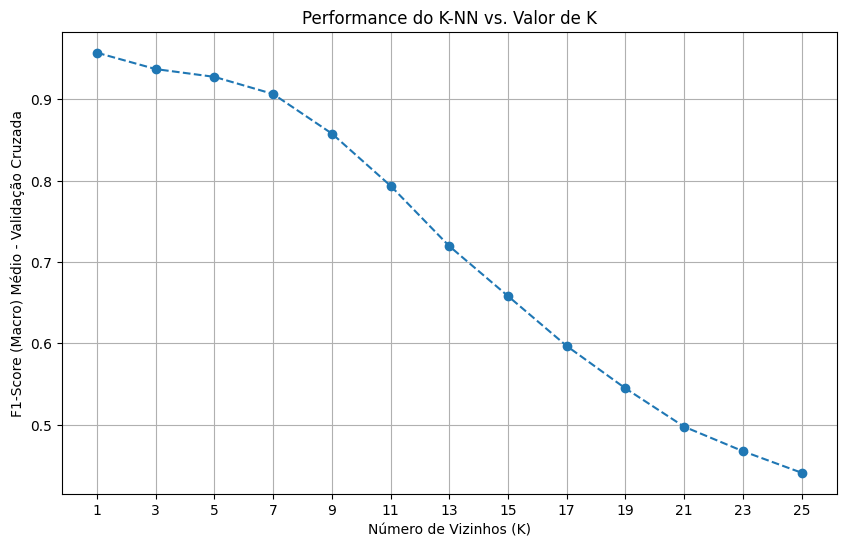

In [26]:
#Vamos visualizar os resultados numa tabela
plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o', linestyle='--')
plt.title('Performance do K-NN vs. Valor de K')
plt.xlabel('Número de Vizinhos (K)')
plt.ylabel('F1-Score (Macro) Médio - Validação Cruzada')
plt.xticks(k_values)
plt.grid(True)


In [27]:
#Entre 5 e 7, escolhemos o 5 por ter maior score médio
modelo_knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Treina o modelo final com todos os dados de treino 
modelo_knn.fit(X_train_scaled, y_train_encoded)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,-1


In [ ]:
# Faz previsões nos dados de teste 
teste_knn = modelo_knn.predict(X_test_scaled)

f1_score_knn = f1_score(y_test_encoded, teste_knn, average='macro')

print(f"\nF1-score final no conjunto de teste: {f1_score_knn:.4f}")


F1-score final no conjunto de teste: 0.9408


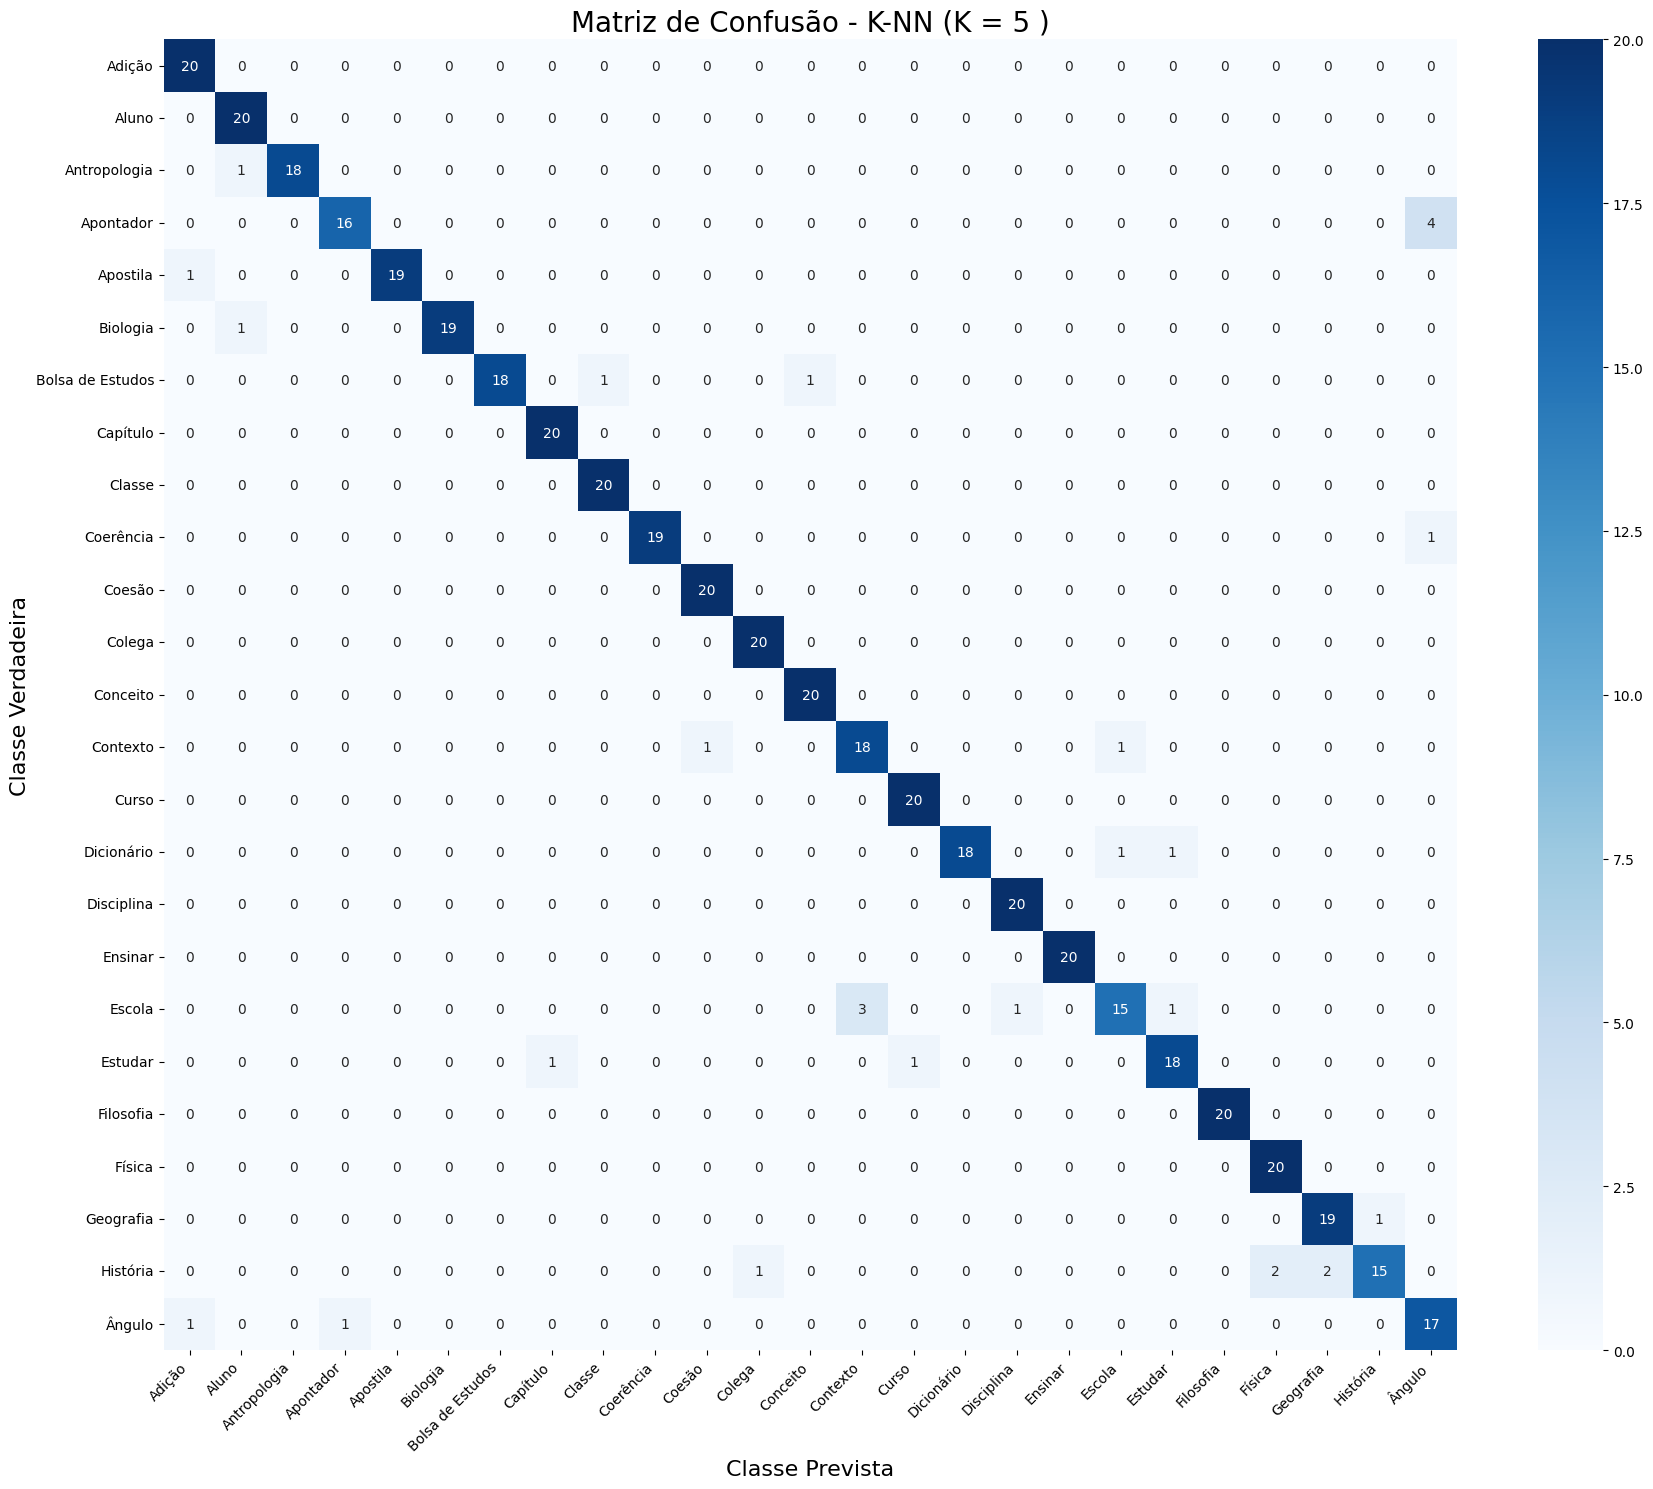

In [ ]:
#Matriz de confusão do KNN
cm_knn = confusion_matrix(y_test_encoded, teste_knn)

nomes_das_classes_knn = label_encoder.classes_


plt.figure(figsize=(18, 15))

sns.heatmap(cm_knn, 
            annot=True,     # Escreve os números dentro de cada célula
            fmt='d',        # Formata os números como inteiros
            cmap='Blues',   # Esquema de cores
            xticklabels=nomes_das_classes_knn, 
            yticklabels=nomes_das_classes_knn)

plt.title(f'Matriz de Confusão - K-NN (K = 5 )', fontsize=20)
plt.ylabel('Classe Verdadeira', fontsize=16)
plt.xlabel('Classe Prevista', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

## Rede Neural (MLP)

In [ ]:
# Começaremos com uma arquitetura rasa: 2 camadas ocultas com 100 neurônios.

mlp = MLPClassifier(
    hidden_layer_sizes=(100, 100),  # Camadas
    activation='relu',              # Função de ativação 
    solver='adam',                  
    max_iter=200,                   # Número máximo de épocas (passagens pelos dados)
    random_state=42,                # Para reprodutibilidade
    early_stopping=True,            # Early stopping para evitar overfitting
    validation_fraction=0.1,        # Separa 10% dos dados de TREINO para validação interna
    n_iter_no_change=15,            # Para o treino se o score de validação não melhorar por 15 épocas seguidas
    verbose=True                    # Mostra o progresso do treinamento (perda a cada época)
)
#Treina com todo o conjunto de treino
mlp.fit(X_train_scaled, y_train_encoded)
#Prediz com o conjunto de teste
teste_mlp_1 = mlp.predict(X_test_scaled)

f1_final_teste1 = f1_score(y_test_encoded, teste_mlp_1, average='macro')
print(f"\nF1-Score (Macro) final no conjunto de teste: {f1_final_teste1:.4f}")


Iteration 1, loss = 3.21798939
Validation score: 0.040000
Iteration 2, loss = 3.06700973
Validation score: 0.110000
Iteration 3, loss = 2.93853721
Validation score: 0.100000
Iteration 4, loss = 2.81184178
Validation score: 0.125000
Iteration 5, loss = 2.69135496
Validation score: 0.150000
Iteration 6, loss = 2.57690401
Validation score: 0.215000
Iteration 7, loss = 2.46827462
Validation score: 0.255000
Iteration 8, loss = 2.36646083
Validation score: 0.260000
Iteration 9, loss = 2.27281657
Validation score: 0.305000
Iteration 10, loss = 2.18336413
Validation score: 0.280000
Iteration 11, loss = 2.09780669
Validation score: 0.315000
Iteration 12, loss = 2.01863516
Validation score: 0.350000
Iteration 13, loss = 1.94137605
Validation score: 0.330000
Iteration 14, loss = 1.86841756
Validation score: 0.345000
Iteration 15, loss = 1.80254134
Validation score: 0.355000
Iteration 16, loss = 1.74123802
Validation score: 0.380000
Iteration 17, loss = 1.68012911
Validation score: 0.365000
Iterat

In [ ]:
# Ainda com 2 camadas ocultas mas com 250 neurônios cada.

mlp = MLPClassifier(
    hidden_layer_sizes=(250, 250),  # Camadas
    activation='relu',              # Função de ativação 
    solver='adam',                  
    max_iter=200,                   # Número máximo de épocas (passagens pelos dados)
    random_state=42,                # Para reprodutibilidade
    early_stopping=True,            # Early stopping para evitar overfitting
    validation_fraction=0.1,        # Separa 10% dos dados de TREINO para validação interna
    n_iter_no_change=15,            # Para o treino se o score de validação não melhorar por 15 épocas seguidas
    verbose=True                    # Mostra o progresso do treinamento (perda a cada época)
)
#Treina com todo o conjunto de treino
mlp.fit(X_train_scaled, y_train_encoded)
#Prediz com o conjunto de teste
teste_mlp_2 = mlp.predict(X_test_scaled)

f1_final_teste2 = f1_score(y_test_encoded, teste_mlp_2, average='macro')
print(f"\nF1-Score (Macro) final no conjunto de teste: {f1_final_teste2:.4f}")

Iteration 1, loss = 3.13853129
Validation score: 0.160000
Iteration 2, loss = 2.86337974
Validation score: 0.210000
Iteration 3, loss = 2.62599239
Validation score: 0.315000
Iteration 4, loss = 2.41538837
Validation score: 0.315000
Iteration 5, loss = 2.23037435
Validation score: 0.390000
Iteration 6, loss = 2.07214309
Validation score: 0.395000
Iteration 7, loss = 1.93861694
Validation score: 0.460000
Iteration 8, loss = 1.82399793
Validation score: 0.480000
Iteration 9, loss = 1.71301525
Validation score: 0.475000
Iteration 10, loss = 1.61891900
Validation score: 0.505000
Iteration 11, loss = 1.53053524
Validation score: 0.550000
Iteration 12, loss = 1.46044067
Validation score: 0.530000
Iteration 13, loss = 1.39694436
Validation score: 0.560000
Iteration 14, loss = 1.33572543
Validation score: 0.605000
Iteration 15, loss = 1.28038279
Validation score: 0.595000
Iteration 16, loss = 1.23479392
Validation score: 0.640000
Iteration 17, loss = 1.18503376
Validation score: 0.615000
Iterat

In [ ]:
# 3 camadas ocultas com 250 neurônios.

mlp = MLPClassifier(
    hidden_layer_sizes=(250, 250, 250),   # Camadas
    activation='relu',              # Função de ativação padrão e mais recomendada
    solver='adam',                  # Otimizador eficiente que funciona bem na maioria dos casos
    max_iter=400,                   # Número máximo de épocas (passagens pelos dados)
    random_state=42,                # Para reprodutibilidade
    early_stopping=True,            # ATIVA o early stopping
    validation_fraction=0.1,        # Separa 10% dos dados de TREINO para validação interna
    n_iter_no_change=15,            # Para o treino se o score de validação não melhorar por 15 épocas seguidas
    verbose=True                    # Mostra o progresso do treinamento (perda a cada época)
)
#Treina com todo o conjunto de treino
mlp.fit(X_train_scaled, y_train_encoded)
#Prediz com o conjunto de teste
teste_mlp_3 = mlp.predict(X_test_scaled)

f1_final_teste3 = f1_score(y_test_encoded, teste_mlp_3, average='macro')
print(f"\nF1-Score (Macro) final no conjunto de teste: {f1_final_teste3:.4f}")

Iteration 1, loss = 3.08667850
Validation score: 0.135000
Iteration 2, loss = 2.74482161
Validation score: 0.200000
Iteration 3, loss = 2.42532926
Validation score: 0.230000
Iteration 4, loss = 2.16922147
Validation score: 0.245000
Iteration 5, loss = 1.96335571
Validation score: 0.300000
Iteration 6, loss = 1.78374297
Validation score: 0.335000
Iteration 7, loss = 1.62849006
Validation score: 0.380000
Iteration 8, loss = 1.50036332
Validation score: 0.425000
Iteration 9, loss = 1.40103130
Validation score: 0.500000
Iteration 10, loss = 1.30173856
Validation score: 0.495000
Iteration 11, loss = 1.22254391
Validation score: 0.545000
Iteration 12, loss = 1.14832777
Validation score: 0.525000
Iteration 13, loss = 1.08603488
Validation score: 0.555000
Iteration 14, loss = 1.03166376
Validation score: 0.555000
Iteration 15, loss = 0.98265084
Validation score: 0.615000
Iteration 16, loss = 0.92993398
Validation score: 0.565000
Iteration 17, loss = 0.88311619
Validation score: 0.645000
Iterat

Até agora, com 2 camadas e 100 neurônios obtivemos melhor resultado. Vamos testar uma última vez, mantendo a quantidade de camadas e aumentar a quantidade de neurônios para 500 e 250.

In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(500, 250),     # Camadas
    activation='relu',              # Função de ativação padrão e mais recomendada
    solver='adam',                  # Otimizador eficiente que funciona bem na maioria dos casos
    max_iter=400,                   # Número máximo de épocas (passagens pelos dados)
    random_state=42,                # Para reprodutibilidade
    early_stopping=True,            # ATIVA o early stopping
    validation_fraction=0.1,        # Separa 10% dos dados de TREINO para validação interna
    n_iter_no_change=15,            # Para o treino se o score de validação não melhorar por 15 épocas seguidas
    verbose=True                    # Mostra o progresso do treinamento (perda a cada época)
)
#Treina com todo o conjunto de treino
mlp.fit(X_train_scaled, y_train_encoded)
#Prediz com o conjunto de teste
teste_mlp_4 = mlp.predict(X_test_scaled)

f1_final_teste4 = f1_score(y_test_encoded, teste_mlp_4, average='macro')
print(f"\nF1-Score (Macro) final no conjunto de teste: {f1_final_teste4:.4f}")

Iteration 1, loss = 3.09694768
Validation score: 0.170000
Iteration 2, loss = 2.76067084
Validation score: 0.220000
Iteration 3, loss = 2.49462097
Validation score: 0.290000
Iteration 4, loss = 2.27062014
Validation score: 0.330000
Iteration 5, loss = 2.08930717
Validation score: 0.395000
Iteration 6, loss = 1.91858206
Validation score: 0.400000
Iteration 7, loss = 1.77739187
Validation score: 0.450000
Iteration 8, loss = 1.65342306
Validation score: 0.465000
Iteration 9, loss = 1.54694680
Validation score: 0.465000
Iteration 10, loss = 1.45627906
Validation score: 0.520000
Iteration 11, loss = 1.37535210
Validation score: 0.525000
Iteration 12, loss = 1.30414611
Validation score: 0.535000
Iteration 13, loss = 1.23752934
Validation score: 0.535000
Iteration 14, loss = 1.17837082
Validation score: 0.605000
Iteration 15, loss = 1.12341527
Validation score: 0.580000
Iteration 16, loss = 1.07161146
Validation score: 0.640000
Iteration 17, loss = 1.02030278
Validation score: 0.610000
Iterat

Como nossa primeira abordagem foi a melhor, iremos defini-la como final e submetê-la a um treinamento mais robusto.

In [37]:
mlp_cv = MLPClassifier(
    hidden_layer_sizes=(100, 100),  # Camadas
    activation='relu',              # Função de ativação 
    solver='adam',                  
    max_iter=200,                   # Número máximo de épocas (passagens pelos dados)
    random_state=42,                # Para reprodutibilidade
    early_stopping=True,            # Early stopping para evitar overfitting
    validation_fraction=0.1,        # Separa 10% dos dados de TREINO para validação interna
    n_iter_no_change=15,            # Para o treino se o score de validação não melhorar por 15 épocas seguidas
    verbose=False                   # Para não poluir a saída com os muitos logs do treinamento
)

kfold_estratificado = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Executar a Validação Cruzada

scores = cross_val_score(
    estimator=mlp_cv,
    X=X_train_scaled,
    y=y_train_encoded,
    cv=kfold_estratificado,
    scoring='f1_macro' 
)

#Analisar os Resultados da Validação Cruzada
print("\nValidação Cruzada concluída.")
print(f"Scores de F1-Score (Macro) para cada um dos 5 folds: {np.round(scores, 3)}")
print(f"F1-Score (Macro) Médio: {scores.mean():.4f}")


Validação Cruzada concluída.
Scores de F1-Score (Macro) para cada um dos 5 folds: [0.818 0.816 0.828 0.859 0.849]
F1-Score (Macro) Médio: 0.8340


In [38]:
# Treina o modelo com todo o conjunto de treino
mlp_cv.fit(X_train_scaled, y_train_encoded)

,hidden_layer_sizes,"(100, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,42


In [39]:
previsoes_finais = mlp_cv.predict(X_test_scaled)
f1_final = f1_score(y_test_encoded, previsoes_finais, average='macro')
print(f"\nF1-Score (Macro) final no conjunto de teste: {f1_final:.4f}")


F1-Score (Macro) final no conjunto de teste: 0.9213


In [40]:
# Relatório de Classificação Detalhado
# Mostra precisão, recall e f1-score para cada uma das 25 classes.

nomes_das_classes = label_encoder.classes_
print(classification_report(y_test_encoded, previsoes_finais, target_names=nomes_das_classes))

                  precision    recall  f1-score   support

          Adição       0.90      0.95      0.93        20
           Aluno       0.94      0.85      0.89        20
    Antropologia       0.95      1.00      0.97        19
       Apontador       0.94      0.75      0.83        20
        Apostila       1.00      0.90      0.95        20
        Biologia       1.00      1.00      1.00        20
Bolsa de Estudos       0.94      0.85      0.89        20
        Capítulo       1.00      0.90      0.95        20
          Classe       1.00      0.90      0.95        20
       Coerência       0.80      1.00      0.89        20
          Coesão       1.00      0.80      0.89        20
          Colega       0.91      1.00      0.95        20
        Conceito       0.91      1.00      0.95        20
        Contexto       0.95      0.90      0.92        20
           Curso       0.87      1.00      0.93        20
      Dicionário       0.86      0.90      0.88        20
      Discipl

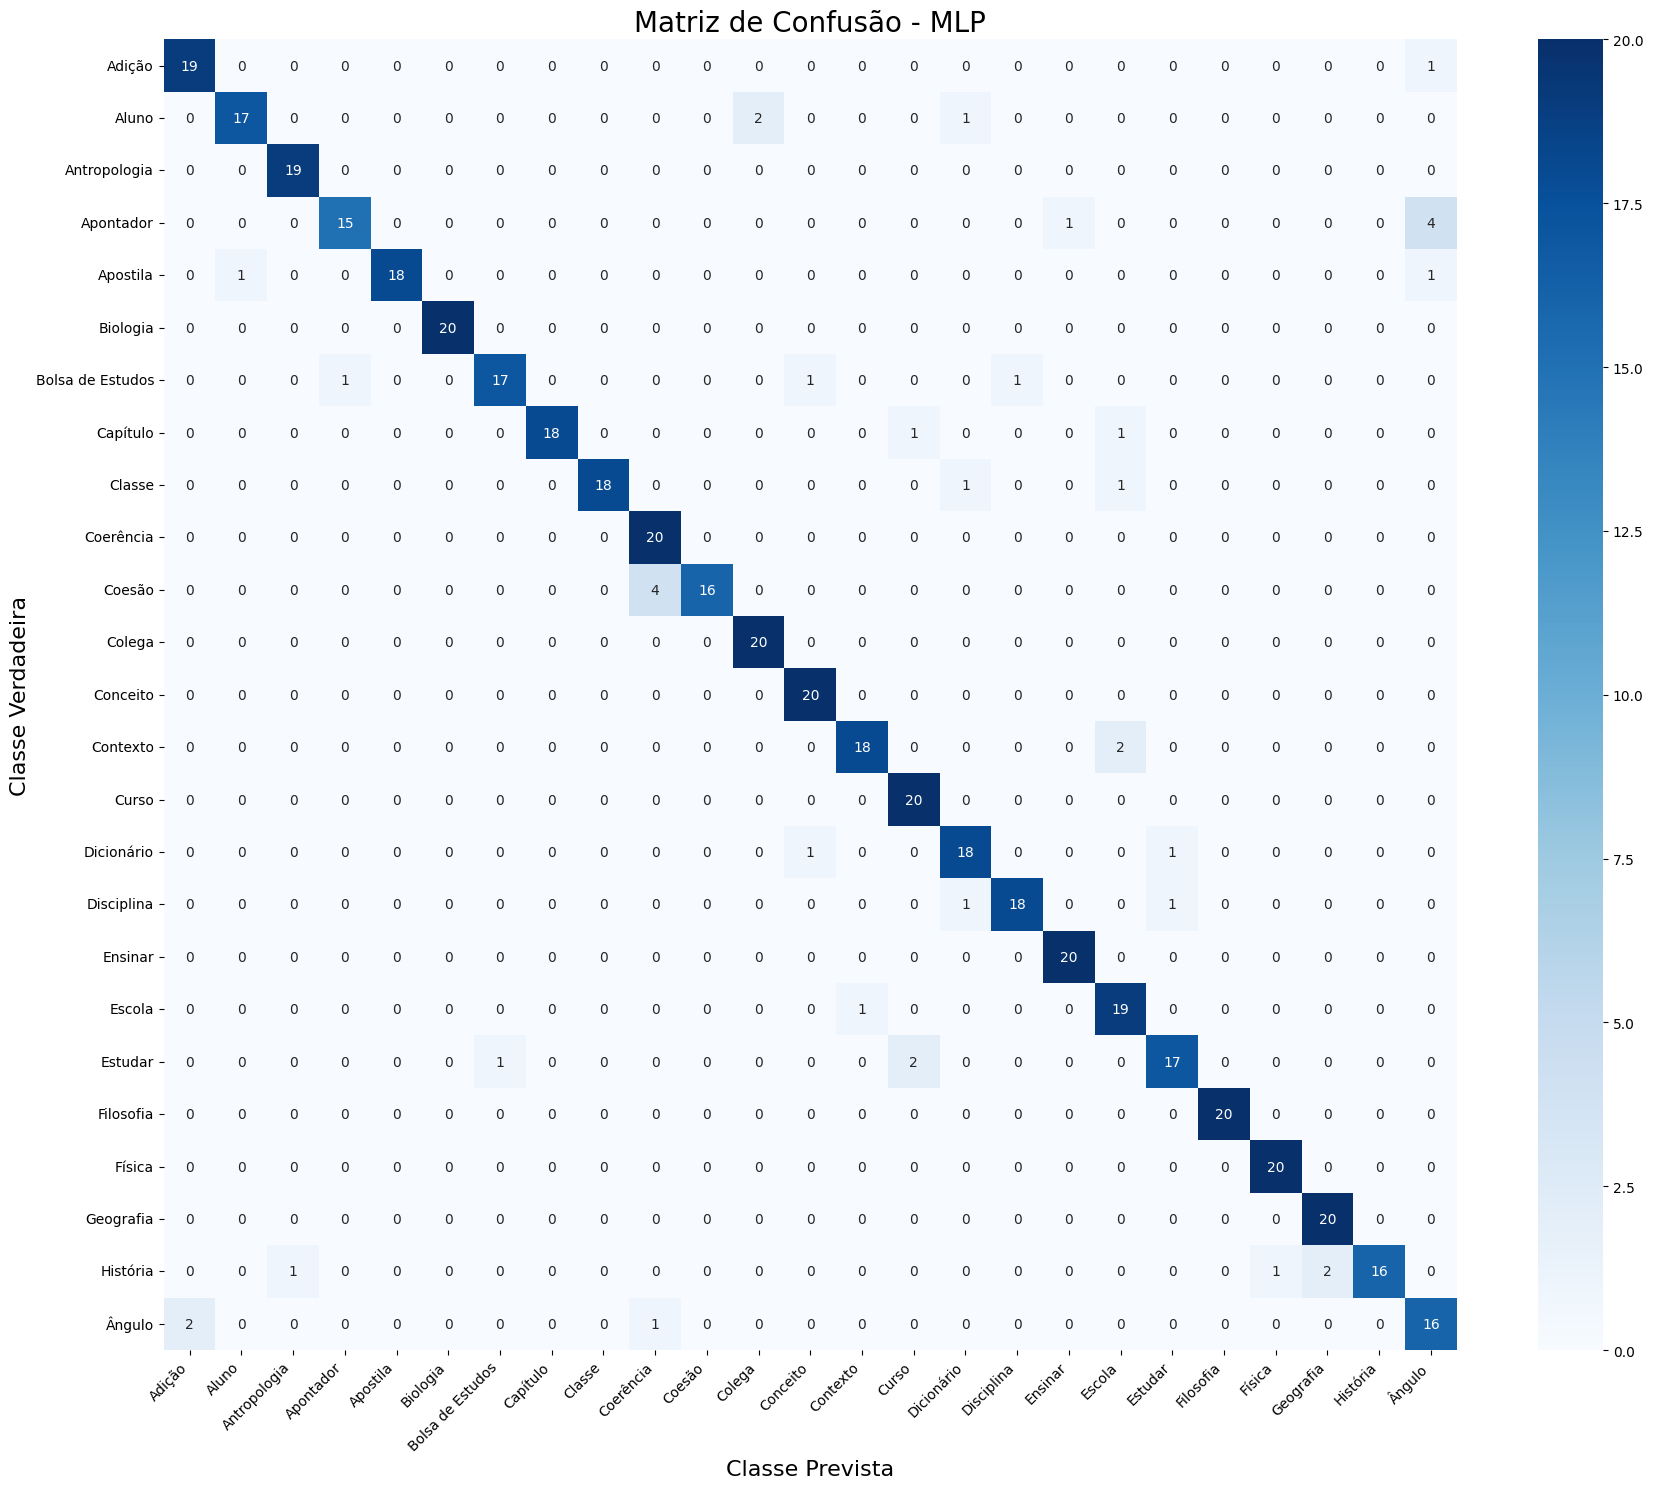

In [41]:
#Matriz de Confusão do MLP
cm = confusion_matrix(y_test_encoded, previsoes_finais)
plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', 
            cmap='Blues', 
            xticklabels=nomes_das_classes, 
            yticklabels=nomes_das_classes)

plt.title('Matriz de Confusão - MLP', fontsize=20)
plt.ylabel('Classe Verdadeira', fontsize=16)
plt.xlabel('Classe Prevista', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


--- Tabela Comparativa de Aprendizagem Supervisionada ---
| Métrica                               |F1_Score (Treino)|   F1_Score (Teste)  |
|:--------------------------------------|----------------:|--------------------:|
| Árvore de decisão                     |          0.9544 |              0.9677 |
| K-Nearest Neighbor                    |          0.9275 |              0.9408 |
| Rede Neural (MLP)                     |         0.8340  |              0.9213 |

# Segunda parte: Aprendizagem Não Supervisionada

Agora, vamos verificar como algoritmos de clusterização combinam os dados previamente preparados para aprendizagem supervisionada. Como não há risco de overfiting,  usaremos todo o conjunto de variáveis independentes. 

*Adendo: em ambos os modelos, juntar ou não o *

In [21]:
#Cópia do dado
X_data = X.copy()

In [22]:
#Verificando
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2490 entries, 0 to 2500
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dist_wrist_r_nose_mean  2490 non-null   float64
 1   dist_wrist_r_nose_std   2490 non-null   float64
 2   dist_wrist_r_nose_min   2490 non-null   float64
 3   dist_wrist_r_nose_max   2490 non-null   float64
 4   dist_wrist_l_nose_mean  2490 non-null   float64
 5   dist_wrist_l_nose_std   2490 non-null   float64
 6   dist_wrist_l_nose_min   2490 non-null   float64
 7   dist_wrist_l_nose_max   2490 non-null   float64
 8   dist_wrists_mean        2490 non-null   float64
 9   dist_wrists_std         2490 non-null   float64
 10  dist_wrists_min         2490 non-null   float64
 11  dist_wrists_max         2490 non-null   float64
 12  vel_wrist_r_mag_mean    2490 non-null   float64
 13  vel_wrist_r_mag_std     2490 non-null   float64
 14  vel_wrist_r_mag_min     2490 non-null   float

## K-means

In [23]:
#Algoritmos de clusterização se beneficiam de features normalizadas.
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

### K-means: K = 25

In [19]:
#Aplicando K-Means com k = 25, pelo número total de sinais
kmeans = KMeans(n_clusters=25, random_state=42)

distances = kmeans.fit_transform(X_data_scaled)

In [ ]:
cluster_labels = kmeans.labels_

# Silhouette Score
# Varia de -1 a 1. Quanto mais perto de 1, melhor definidos são os clusters.
sil_score = silhouette_score(X_data_scaled, cluster_labels, metric='euclidean')

# Davies-Bouldin Score
# O valor mínimo é 0. Quanto mais perto de 0, melhor a partição dos clusters.
db_score = davies_bouldin_score(X_data_scaled, cluster_labels)

# Calinski-Harabasz Score
# Não tem um limite superior. Quanto maior o score, mais densos e bem separados são os clusters.
ch_score = calinski_harabasz_score(X_data_scaled, cluster_labels)


# EXIBIÇÃO DOS RESULTADOS 
print(f"Silhouette Score : {sil_score:.4f}")
print(f"Davies-Bouldin Score : {db_score:.4f}")
print(f"Calinski-Harabasz Score : {ch_score:.2f}")


Silhouette Score : 0.3108
Davies-Bouldin Score : 1.1677
Calinski-Harabasz Score : 1128.07


Pelos resultados anteriores, temos clusters pouco definidos, com baixa qualidade de particionamento, porém densos. É provável que isso resulte do balanceamento das classes das amostras.
Vamos utilizar o método do cotovelo para analisar um melhor K para avaliar.

### K-means: Cotovelo

Passo 1: Encontrando o número ideal de clusters (K) com o Método do Cotovelo...


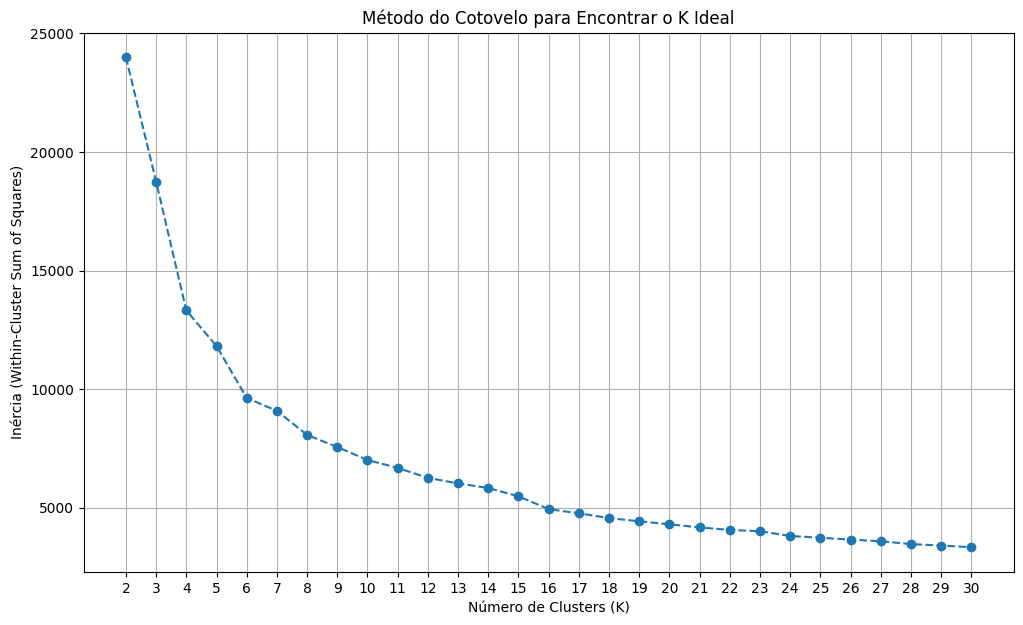

In [ ]:
# Lista para armazenar a inércia (soma das distâncias quadráticas intra-cluster)
inertias = []
# Vamos testar um range de K. Como sabemos que há 25 classes, vamos testar até um pouco mais.
k_range = range(2, 31) 

for k in k_range:
    # n_init='auto' faz a saída não mostrar possíveis avisos durante a execução.
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_data_scaled)
    inertias.append(kmeans.inertia_)

# Plotando o gráfico do cotovelo
plt.figure(figsize=(12, 7))
plt.plot(k_range, inertias, marker='o', linestyle='--')
plt.title('Método do Cotovelo para Encontrar o K Ideal')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (Within-Cluster Sum of Squares)')
plt.xticks(k_range)
plt.grid(True)

In [ ]:
#A última queda mais abrupta acontece com k = 8. Sendo assim, vamos com esse valor
kmeans_2 = KMeans(n_clusters=8, random_state=42)

distances_2 = kmeans_2.fit_transform(X_data_scaled)   

In [ ]:
cluster_labels = kmeans_2.labels_

# Silhouette Score
# Varia de -1 a 1. Quanto mais perto de 1, melhor definidos são os clusters.
sil_score = silhouette_score(X_data_scaled, cluster_labels, metric='euclidean')

# Davies-Bouldin Score
# O valor mínimo é 0. Quanto mais perto de 0, melhor a partição dos clusters.
db_score = davies_bouldin_score(X_data_scaled, cluster_labels)

# Calinski-Harabasz Score
# Não tem um limite superior. Quanto maior o score, mais densos e bem separados são os clusters.
ch_score = calinski_harabasz_score(X_data_scaled, cluster_labels)


# EXIBIÇÃO DOS RESULTADOS 
print(f"Silhouette Score para k = 8: {sil_score:.4f}")
print(f"Davies-Bouldin Score para k = 8: {db_score:.4f}")
print(f"Calinski-Harabasz Score para k = 8: {ch_score:.2f}")

Silhouette Score para k = 8: 0.2956
Davies-Bouldin Score para k = 8: 1.1528
Calinski-Harabasz Score para k = 8: 1613.85


É... pelo calinski ainda temos grupos bem densos mas as outras métricas ainda deixam a desejar. Que tal outra abordagem? 
Vamos agora testar o modelo de clusterização hierárquico, variando o método de linkage (diferença descrita em cada momento).

## Hierárquico

### Linkage: Ward

O primeiro passo será a visualização do dendrograma. Um dendrograma é um gráfico em forma de árvore que representa o agrupamento hierárquico de dados, ilustrando os níveis de similaridade entre as observações à medida que são combinadas. 

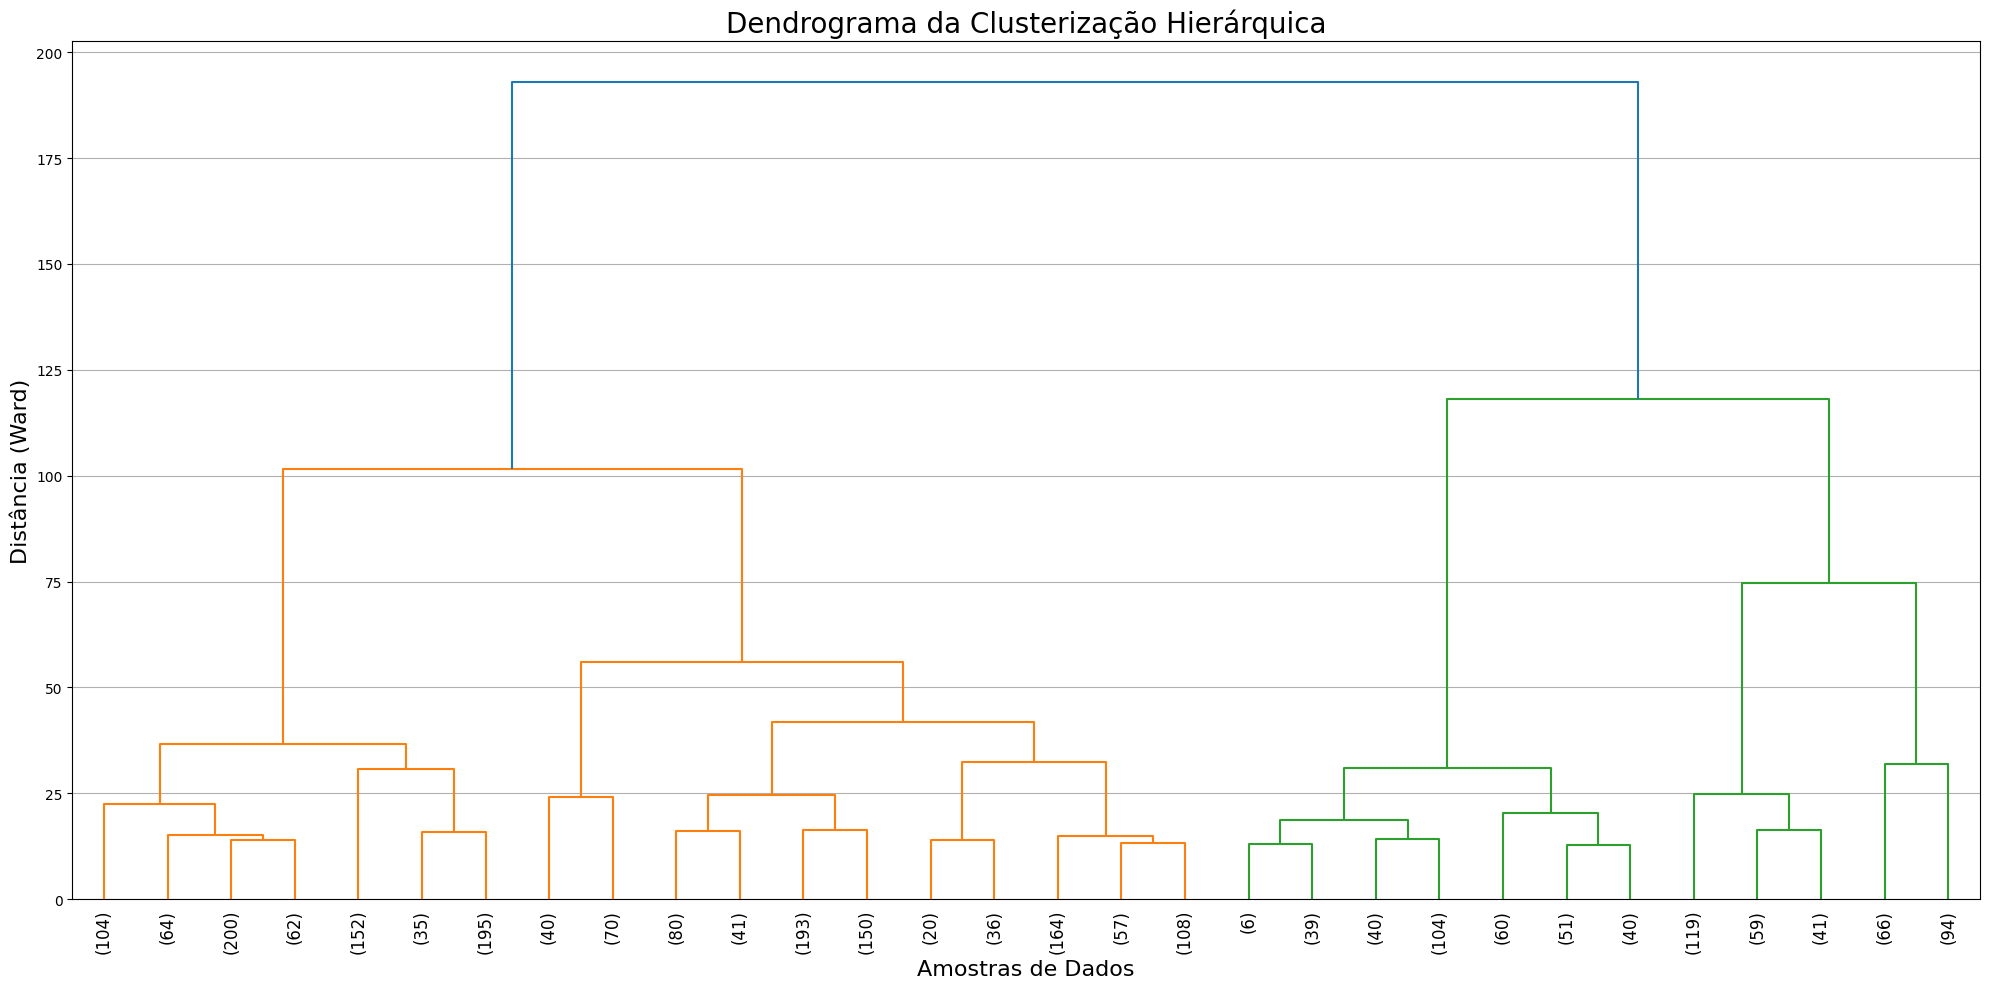

In [ ]:
# A distância entre clusters é calculada usando o método de Ward,
# que minimiza a variância total dentro dos clusters.
# Isso tende a criar clusters de tamanho relativamente similar.
# Por isso nosso primeiro método de ligação será o 'ward'.
linked = linkage(X_data_scaled, method='ward')

# Plotando o dendrograma
plt.figure(figsize=(20, 10))
plt.title('Dendrograma para Clusterização Hierárquica', fontsize=20)
plt.xlabel('Amostras de Dados', fontsize=16)
plt.ylabel('Distância (Ward)', fontsize=16)

# O dendrograma completo com todas as amostras seria ilegível.
# 'truncate_mode='lastp'' mostra apenas as últimas 'p' fusões de clusters,
# que é a parte mais importante para a análise.
dendrogram(linked,
           truncate_mode='lastp',
           p=30,  # Mostra as últimas 30 fusões.
           show_leaf_counts=True,
           leaf_rotation=90.,
           leaf_font_size=12.)

plt.grid(axis='y')
plt.tight_layout()


Visualizando o gráfico, olhando de baixo para cima, vemos que entre 25 e 50 a hierarquia vai se estabilizando (formação de grandes conjuntos). Se traçarmos uma linha imaginária entre os números previamente citados e que passa pelo pequeno espaço que fica abaixo da linha horizontal que aparenta estar exatamente na metade do espaço entre 25 e 50, o número de linhas verticais 'cortadas' do começo ao fim do gráfico é 8, coincidindo com o melhor no teste do cotovelo para o K-means. 

In [ ]:
# Inicializa e executa o AgglomerativeClustering
K_AC = 8  
agg_cluster = AgglomerativeClustering(n_clusters=K_AC, linkage='ward')
cluster_labels_AC = agg_cluster.fit_predict(X_data_scaled)

print("Clusterização concluída. Calculando métricas de avaliação...")

# Calcula as métricas de avaliação
sil_score_AC = silhouette_score(X_data_scaled, cluster_labels_AC)
db_score_AC = davies_bouldin_score(X_data_scaled, cluster_labels_AC)
ch_score_AC = calinski_harabasz_score(X_data_scaled, cluster_labels_AC)

# Exibe os resultados
print("\n--- Resultados da Avaliação da Clusterização ---")
print(f"Para K = {K_AC}:")
print(f"  - Silhouette Score : {sil_score_AC:.4f}")
print(f"  - Davies-Bouldin Score : {db_score_AC:.4f}")
print(f"  - Calinski-Harabasz Score : {ch_score_AC:.2f}")

Clusterização concluída. Calculando métricas de avaliação...

--- Resultados da Avaliação da Clusterização ---
Para K = 8:
  - Silhouette Score : 0.3040
  - Davies-Bouldin Score : 1.1744
  - Calinski-Harabasz Score : 1595.58


--- Tabela Comparativa de Métricas de Clusterização ---
| Métrica                               |   K-Means (K=8) |   Hierárquico (K=8) |
|:--------------------------------------|----------------:|--------------------:|
| Silhouette Score (↑ melhor)           |          0.2956 |              0.3040 |
| Davies-Bouldin Score (↓ melhor)       |          1.1528 |              1.1744 |
| Calinski-Harabasz Score (↑ melhor)    |         1613.85 |             1595.58 |

### Linkage: Complete

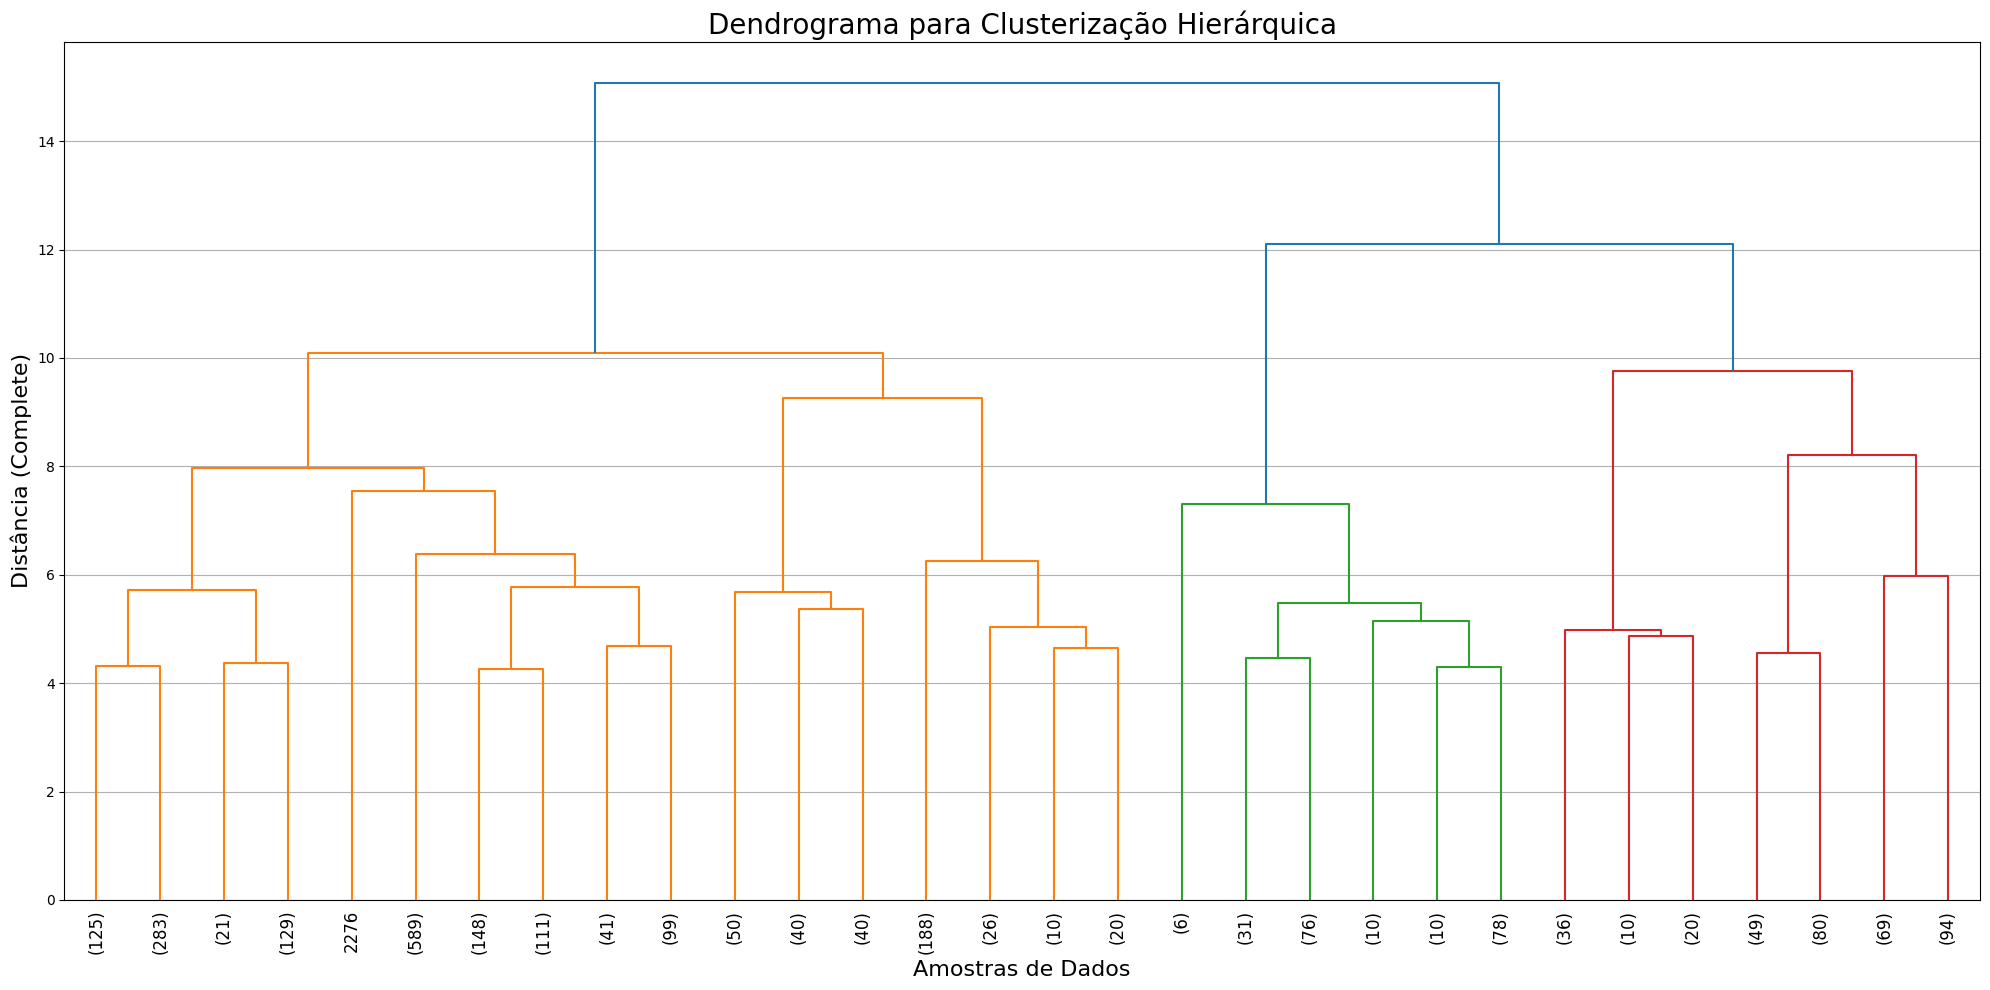

In [ ]:
# O método 'complete' considera a distância máxima entre pontos de diferentes clusters.
# Isso tende a criar clusters mais compactos e separados.
# Vamos ver como fica o dendrograma com esse método.
linked = linkage(X_data_scaled, method='complete')

# Plotando o dendrograma
plt.figure(figsize=(20, 10))
plt.title('Dendrograma para Clusterização Hierárquica', fontsize=20)
plt.xlabel('Amostras de Dados', fontsize=16)
plt.ylabel('Distância (Complete)', fontsize=16)


dendrogram(linked,
           truncate_mode='lastp',
           p=30,  
           show_leaf_counts=True,
           leaf_rotation=90.,
           leaf_font_size=12.)

plt.grid(axis='y')
plt.tight_layout()

A hierarquia começa a se estabilizar próximo do valor de distância 8. Trançando uma linha imaginária logo abaixo desse valor, encontramos o valor 8, coincidindo com o teste do cotovelo no K-means.

In [34]:
K_AC_2 = 8  
agg_cluster = AgglomerativeClustering(n_clusters=K_AC, linkage='complete')
cluster_labels_AC_2 = agg_cluster.fit_predict(X_data_scaled)

print("Clusterização concluída. Calculando métricas de avaliação...")

# Calcula as métricas de avaliação
sil_score_AC = silhouette_score(X_data_scaled, cluster_labels_AC_2)
db_score_AC = davies_bouldin_score(X_data_scaled, cluster_labels_AC_2)
ch_score_AC = calinski_harabasz_score(X_data_scaled, cluster_labels_AC_2)

# Exibe os resultados
print("\n--- Resultados da Avaliação da Clusterização ---")
print(f"Para K = {K_AC}:")
print(f"  - Silhouette Score : {sil_score_AC:.4f}")
print(f"  - Davies-Bouldin Score : {db_score_AC:.4f}")
print(f"  - Calinski-Harabasz Score : {ch_score_AC:.2f}")

Clusterização concluída. Calculando métricas de avaliação...

--- Resultados da Avaliação da Clusterização ---
Para K = 8:
  - Silhouette Score : 0.2479
  - Davies-Bouldin Score : 1.3463
  - Calinski-Harabasz Score : 1159.38


--- Tabela Comparativa de Linkages para K = 8---
| Métrica / Linkage                               |   Ward  |   Complete  |
|:--------------------------------------|----------------:|--------------------:|
| Silhouette Score (↑ melhor)           |          0.3040 |              0.2479 |
| Davies-Bouldin Score (↓ melhor)       |          1.1744 |              1.3463 |
| Calinski-Harabasz Score (↑ melhor)    |         1595.58 |             1159.38 |

Pode-se concluir que os dados que temos não carregam muita especificidade de suas instâncias, de forma que esses modelos possam agrupá-los de maneira mais precisa.